<a href="https://colab.research.google.com/github/samiha-mahin/WaterQuality/blob/main/WQ_DT_MLP_RNN_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install imbalanced-learn

## **Decision** **Tree**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load and preprocess the dataset
df = pd.read_csv('resampled_SMOTEENN.csv')
X = df.drop('Potability', axis=1).values
y = df['Potability'].values

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Decision Tree Node
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

# Gini impurity
def gini(y):
    proportions = [np.sum(y == c) / len(y) for c in np.unique(y)]
    return 1 - sum(p**2 for p in proportions)

# Split dataset
def split(X, y, feature, threshold):
    left_idx = np.where(X[:, feature] <= threshold)
    right_idx = np.where(X[:, feature] > threshold)
    return X[left_idx], y[left_idx], X[right_idx], y[right_idx]

# Best split
def best_split(X, y):
    best_gain = -1
    split_idx, split_thresh = None, None
    for feature in range(X.shape[1]):
        thresholds = np.unique(X[:, feature])
        for threshold in thresholds:
            X_left, y_left, X_right, y_right = split(X, y, feature, threshold)
            if len(y_left) == 0 or len(y_right) == 0:
                continue

            # Weighted gini
            gini_left = gini(y_left)
            gini_right = gini(y_right)
            gini_total = (len(y_left) / len(y)) * gini_left + (len(y_right) / len(y)) * gini_right

            gain = gini(y) - gini_total
            if gain > best_gain:
                best_gain = gain
                split_idx = feature
                split_thresh = threshold
    return split_idx, split_thresh

# Build tree
def build_tree(X, y, depth=0, max_depth=10, min_samples=2):
    if len(set(y)) == 1 or len(y) < min_samples or depth >= max_depth:
        leaf_value = np.bincount(y).argmax()
        return Node(value=leaf_value)

    feature, threshold = best_split(X, y)
    if feature is None:
        leaf_value = np.bincount(y).argmax()
        return Node(value=leaf_value)

    X_left, y_left, X_right, y_right = split(X, y, feature, threshold)
    left = build_tree(X_left, y_left, depth + 1, max_depth, min_samples)
    right = build_tree(X_right, y_right, depth + 1, max_depth, min_samples)
    return Node(feature, threshold, left, right)

# Prediction
def predict_single(x, node):
    while not node.is_leaf_node():
        if x[node.feature] <= node.threshold:
            node = node.left
        else:
            node = node.right
    return node.value

def predict(X, tree):
    return np.array([predict_single(x, tree) for x in X])

# Train the tree
tree = build_tree(X_train, y_train, max_depth=10)

# Predict and evaluate
y_pred = predict(X_test, tree)
accuracy = np.mean(y_pred == y_test)
print(f"Decision Tree Accuracy: {accuracy * 100:.2f}%")


Decision Tree Accuracy: 70.38%


## **Decision Tree ( Hyperparameter Tuning )**

In [ ]:
import numpy as np
import pandas as pd

# Load and preprocess dataset
df = pd.read_csv('resampled_SMOTEENN.csv')
X = df.drop('Potability', axis=1).values
y = df['Potability'].values

# Normalize manually (optional but common for trees)
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Manual train-test split (80-20)
def train_test_split_manual(X, y, test_size=0.2, seed=42):
    np.random.seed(seed)
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    split = int(len(X) * (1 - test_size))
    train_idx, test_idx = indices[:split], indices[split:]
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

X_train, X_test, y_train, y_test = train_test_split_manual(X, y)

# -------------------------------
# Decision Tree from Scratch
# -------------------------------

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf(self):
        return self.value is not None

def gini(y):
    classes = np.unique(y)
    g = 1.0
    for c in classes:
        p = np.sum(y == c) / len(y)
        g -= p ** 2
    return g

def split_dataset(X, y, feature, threshold):
    left_mask = X[:, feature] <= threshold
    right_mask = X[:, feature] > threshold
    return X[left_mask], y[left_mask], X[right_mask], y[right_mask]

def best_split(X, y):
    best_gain = -1
    best_feature, best_thresh = None, None
    n_features = X.shape[1]

    for feature in range(n_features):
        thresholds = np.unique(X[:, feature])
        for threshold in thresholds:
            X_left, y_left, X_right, y_right = split_dataset(X, y, feature, threshold)
            if len(y_left) == 0 or len(y_right) == 0:
                continue

            gini_parent = gini(y)
            gini_left = gini(y_left)
            gini_right = gini(y_right)

            weighted_gini = (len(y_left)/len(y)) * gini_left + (len(y_right)/len(y)) * gini_right
            gain = gini_parent - weighted_gini

            if gain > best_gain:
                best_gain = gain
                best_feature = feature
                best_thresh = threshold

    return best_feature, best_thresh

def build_tree(X, y, max_depth, min_samples, depth=0):
    if len(set(y)) == 1 or len(y) < min_samples or depth >= max_depth:
        leaf_value = np.bincount(y).argmax()
        return Node(value=leaf_value)

    feature, threshold = best_split(X, y)
    if feature is None:
        return Node(value=np.bincount(y).argmax())

    X_left, y_left, X_right, y_right = split_dataset(X, y, feature, threshold)

    left = build_tree(X_left, y_left, max_depth, min_samples, depth + 1)
    right = build_tree(X_right, y_right, max_depth, min_samples, depth + 1)

    return Node(feature, threshold, left, right)

def predict_sample(x, node):
    while not node.is_leaf():
        if x[node.feature] <= node.threshold:
            node = node.left
        else:
            node = node.right
    return node.value

def predict(X, tree):
    return np.array([predict_sample(x, tree) for x in X])

# -------------------------------
# Hyperparameter Tuning
# -------------------------------

def evaluate(X_train, y_train, X_test, y_test, max_depth, min_samples):
    tree = build_tree(X_train, y_train, max_depth=max_depth, min_samples=min_samples)
    y_pred = predict(X_test, tree)
    acc = np.sum(y_pred == y_test) / len(y_test)
    return acc

# Grid search
max_depths = [3, 5, 7, 10]
min_samples_list = [2, 5, 10]

best_acc = 0
best_params = {}

for max_depth in max_depths:
    for min_samples in min_samples_list:
        acc = evaluate(X_train, y_train, X_test, y_test, max_depth, min_samples)
        print(f"max_depth={max_depth}, min_samples={min_samples} => Accuracy: {acc:.4f}")
        if acc > best_acc:
            best_acc = acc
            best_params = {'max_depth': max_depth, 'min_samples': min_samples}

print(f"\n✅ Best Accuracy: {best_acc:.4f} with parameters: {best_params}")


max_depth=3, min_samples=2 => Accuracy: 0.6423
max_depth=3, min_samples=5 => Accuracy: 0.6423
max_depth=3, min_samples=10 => Accuracy: 0.6423
max_depth=5, min_samples=2 => Accuracy: 0.7154
max_depth=5, min_samples=5 => Accuracy: 0.7154
max_depth=5, min_samples=10 => Accuracy: 0.7154
max_depth=7, min_samples=2 => Accuracy: 0.7231
max_depth=7, min_samples=5 => Accuracy: 0.7269
max_depth=7, min_samples=10 => Accuracy: 0.7346
max_depth=10, min_samples=2 => Accuracy: 0.7423
max_depth=10, min_samples=5 => Accuracy: 0.7385
max_depth=10, min_samples=10 => Accuracy: 0.7500

✅ Best Accuracy: 0.7500 with parameters: {'max_depth': 10, 'min_samples': 10}


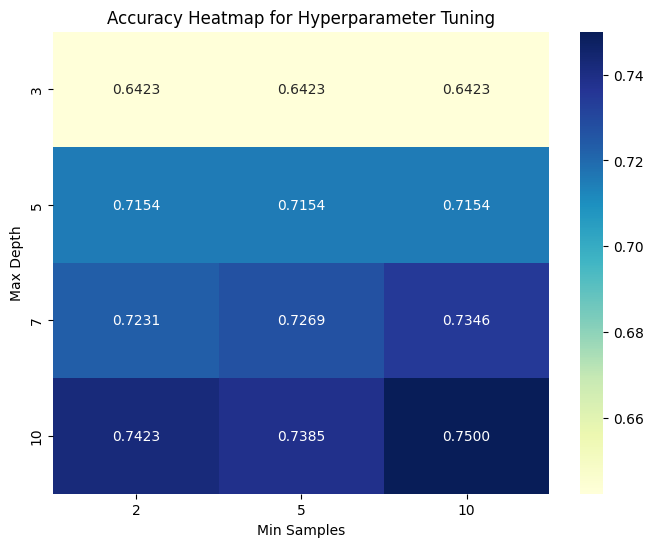

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Grid search results
max_depths = [3, 5, 7, 10]
min_samples_list = [2, 5, 10]

# Store accuracies in a matrix (rows = max_depths, columns = min_samples_list)
accuracy_matrix = np.zeros((len(max_depths), len(min_samples_list)))

# Fill the accuracy matrix
for i, max_depth in enumerate(max_depths):
    for j, min_samples in enumerate(min_samples_list):
        acc = evaluate(X_train, y_train, X_test, y_test, max_depth, min_samples)
        accuracy_matrix[i, j] = acc

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(accuracy_matrix, annot=True, fmt=".4f", cmap="YlGnBu", xticklabels=min_samples_list, yticklabels=max_depths)

# Labels and title
plt.xlabel("Min Samples")
plt.ylabel("Max Depth")
plt.title("Accuracy Heatmap for Hyperparameter Tuning")

# Show the plot
plt.show()


# **MLP**

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


✅ Best MLP Model Accuracy: 0.8769230769230769
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.79      0.84       104
           1       0.87      0.94      0.90       156

    accuracy                           0.88       260
   macro avg       0.88      0.86      0.87       260
weighted avg       0.88      0.88      0.88       260



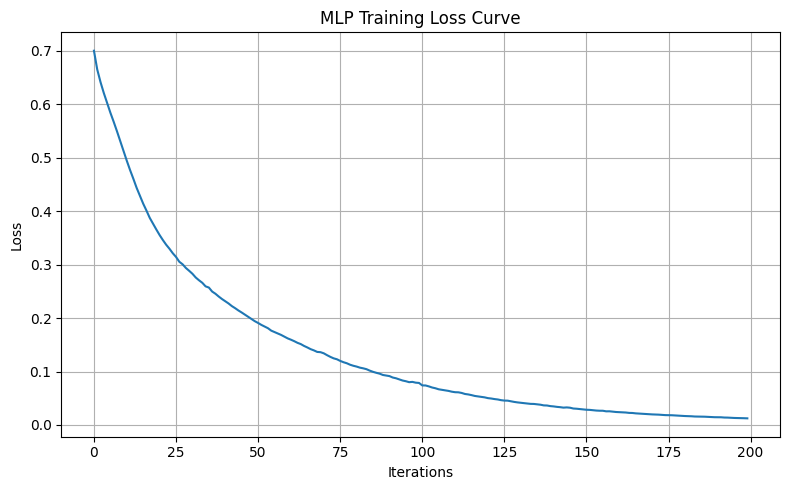

<ipython-input-11-f21f7a71dca8>:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Test Accuracy"], y=[accuracy], palette="viridis")


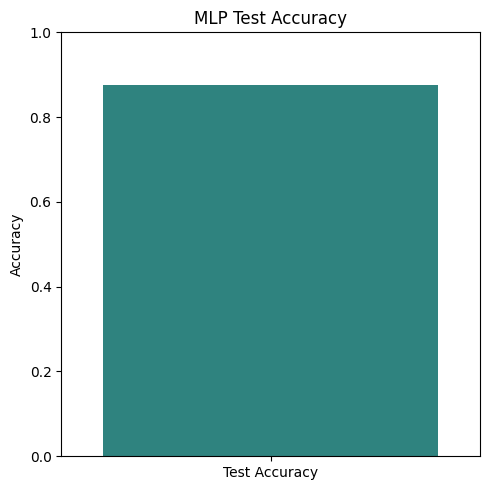

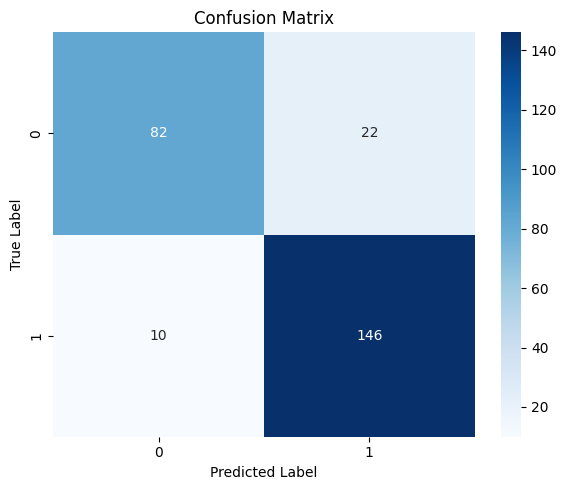

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Load dataset
df = pd.read_csv("resampled_SMOTEENN.csv")

# Step 2: Feature Engineering
df["Solids_per_Hardness"] = df["Solids"] / (df["Hardness"] + 1e-5)
df["pH_Turbidity"] = df["ph"] * df["Turbidity"]
df["Sulfate_Chloramines"] = df["Sulfate"] * df["Chloramines"]

# Step 3: Features and Target
X = df.drop("Potability", axis=1)
y = df["Potability"]

# Step 4: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Step 5: Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 6: SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# Step 7: MLP Hyperparameters
param_grid = {
    'hidden_layer_sizes': [(100,), (100, 50)],
    'activation': ['relu'],
    'solver': ['adam'],
    'max_iter': [200],
    'learning_rate': ['constant', 'adaptive'],
}

# Step 8: Grid Search
mlp_model = MLPClassifier(random_state=42)
grid_search = GridSearchCV(mlp_model, param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_resampled, y_resampled)

# Step 9: Best model
best_mlp_model = grid_search.best_estimator_

# Step 10: Evaluation
y_pred = best_mlp_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Step 11: Output results
print("✅ Best MLP Model Accuracy:", accuracy)
print("📊 Classification Report:\n", report)

# Step 12: Plot Loss Curve
plt.figure(figsize=(8, 5))
plt.plot(best_mlp_model.loss_curve_)
plt.title("MLP Training Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 13: Plot Accuracy using Seaborn
plt.figure(figsize=(5, 5))
sns.barplot(x=["Test Accuracy"], y=[accuracy], palette="viridis")
plt.ylim(0, 1)
plt.title("MLP Test Accuracy")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

# Step 14: Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [13]:
!pip install shap lime


In [ ]:
import shap
import matplotlib.pyplot as plt

# SHAP works best with tree-based models, but it can still be applied to MLP using KernelExplainer
explainer_shap = shap.KernelExplainer(best_mlp_model.predict_proba, shap.sample(X_test_scaled, 100))
shap_values = explainer_shap.shap_values(X_test_scaled[:50])  # Limit instances for speed

# Summary plot (global explanation)
# Use the first 50 rows of X_test to match the shap_values
shap.summary_plot(shap_values, X_test.iloc[:50], feature_names=X.columns)

# Get SHAP values for the first instance
shap_values_instance = explainer_shap.shap_values(X_test_scaled[0])[1]  # [1] for class 1 probability

# Create bar plot
plt.show()

In [ ]:
import lime
import lime.lime_tabular

# Create a LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled,
    feature_names=X.columns.tolist(),
    class_names=["Not Potable", "Potable"],
    mode='classification'
)

# Choose a sample to explain
idx = 0
lime_exp = lime_explainer.explain_instance(
    X_test_scaled[idx],
    best_mlp_model.predict_proba,
    num_features=5
)

# Show explanation
lime_exp.show_in_notebook(show_table=True)


# **RNN**

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5228 - loss: 0.9145 - val_accuracy: 0.6423 - val_loss: 0.6594
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6187 - loss: 0.7144 - val_accuracy: 0.6808 - val_loss: 0.6290
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6431 - loss: 0.6696 - val_accuracy: 0.6962 - val_loss: 0.6016
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6938 - loss: 0.5903 - val_accuracy: 0.7654 - val_loss: 0.5592
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7264 - loss: 0.5432 - val_accuracy: 0.7346 - val_loss: 0.5372
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7175 - loss: 0.5473 - val_accuracy: 0.7808 - val_loss: 0.4895
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7653 - loss: 0.4879 - val_accuracy: 0.7923 - val_loss: 0.4657
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7393 - loss: 0.5021 - val_accuracy: 0.8192 - val_loss: 0.

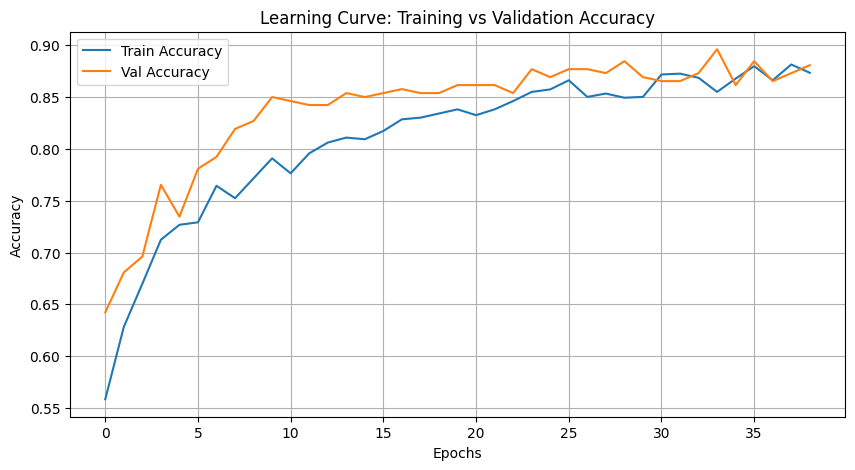

In [12]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Step 1: Load and engineer features
df = pd.read_csv("resampled_SMOTEENN.csv")

# Feature Engineering
df["Solids_per_Hardness"] = df["Solids"] / (df["Hardness"] + 1e-5)
df["pH_Turbidity"] = df["ph"] * df["Turbidity"]
df["Sulfate_Chloramines"] = df["Sulfate"] * df["Chloramines"]

# Step 2: Features and labels
X = df.drop("Potability", axis=1)
y = df["Potability"]

# Step 3: Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 4: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Handle class imbalance using SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# Step 6: Define the neural network model from scratch
def create_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Step 7: Create and train the model
model = create_model((X_resampled.shape[1],))  # The input shape is the number of features

# Train the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_resampled, y_resampled,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_test_scaled, y_test),
                    callbacks=[early_stopping],
                    verbose=1)

# Step 8: Evaluate the model on test data
y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")

# Step 9: Evaluate and print performance metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Deep Learning Accuracy: {accuracy:.4f}")
print("📊 Classification Report:\n", classification_report(y_test, y_pred))

# Step 10: Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Learning Curve: Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# **DNN**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5583 - loss: 0.6847 - val_accuracy: 0.5577 - val_loss: 0.6622
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6336 - loss: 0.6344 - val_accuracy: 0.6192 - val_loss: 0.6266
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6720 - loss: 0.5975 - val_accuracy: 0.7154 - val_loss: 0.5673
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7202 - loss: 0.5562 - val_accuracy: 0.7462 - val_loss: 0.5262
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7301 - loss: 0.5170 - val_accuracy: 0.7577 - val_loss: 0.4927
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7900 - loss: 0.4670 - val_accuracy: 0.7769 - val_loss: 0.4818
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7671 - loss: 0.4728 - val_accuracy: 0.7846 - val_loss: 0.4644
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7768 - loss: 0.4567 - val_accuracy: 0.8077 - val_loss

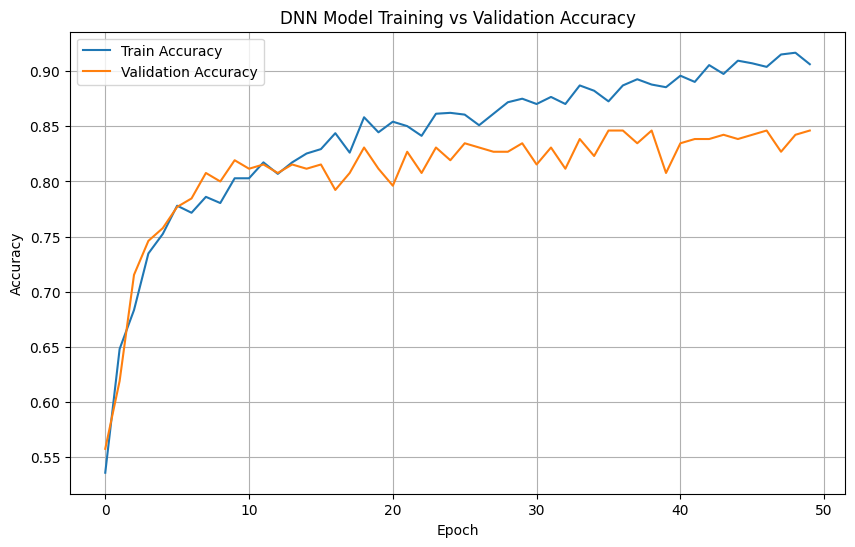

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import tensorflow as tf
import matplotlib.pyplot as plt

# Step 1: Load and engineer features
df = pd.read_csv("resampled_SMOTEENN.csv")

# Handle missing values
df = df.fillna(df.mean())  # Replace missing values with column mean

# Feature engineering (creating new features based on the dataset)
df["Solids_per_Hardness"] = df["Solids"] / (df["Hardness"] + 1e-5)
df["pH_Turbidity"] = df["ph"] * df["Turbidity"]
df["Sulfate_Chloramines"] = df["Sulfate"] * df["Chloramines"]

# Step 2: Features and labels
X = df.drop("Potability", axis=1)
y = df["Potability"]

# Step 3: Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 4: Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Apply PCA to reduce dimensionality
pca = PCA(n_components=0.95)  # Keep 95% of the variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Step 6: Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_pca, y_train)

# Step 7: Build DNN Model (Deep Neural Network)
dnn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_pca.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

dnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 8: Train the model
history_dnn = dnn_model.fit(X_resampled, y_resampled, epochs=50, batch_size=32, validation_data=(X_test_pca, y_test), verbose=1)

# Step 9: Evaluate the model
y_pred_dnn = (dnn_model.predict(X_test_pca) > 0.5).astype("int32")
acc_dnn = accuracy_score(y_test, y_pred_dnn)

# Display results
print(f"DNN Accuracy: {acc_dnn}")
print("📊 Classification Report (DNN):\n", classification_report(y_test, y_pred_dnn))

# Step 10: Plot accuracy for the DNN model
plt.figure(figsize=(10, 6))
plt.plot(history_dnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_dnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('DNN Model Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# **Data Visualization**

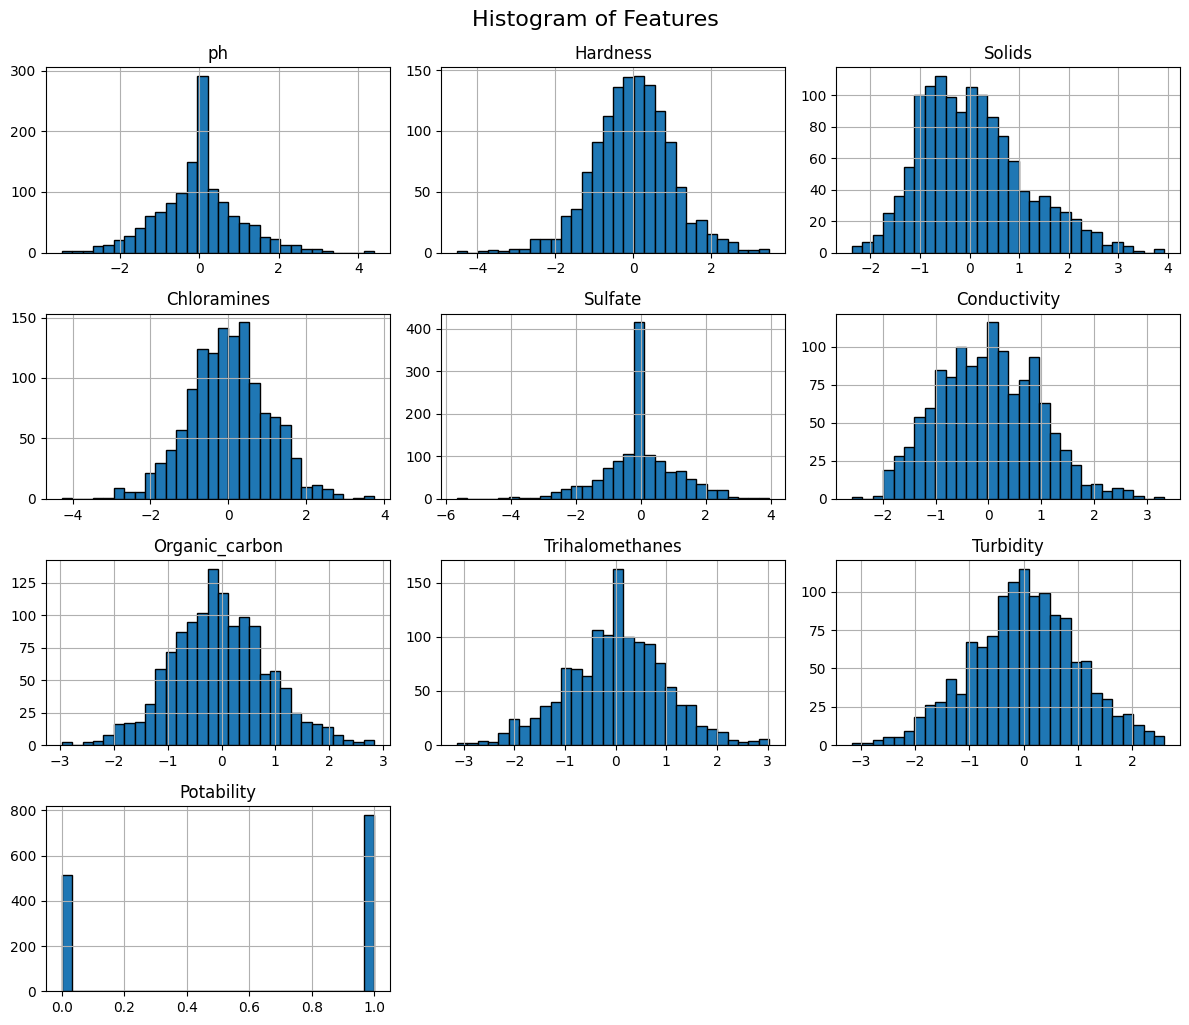

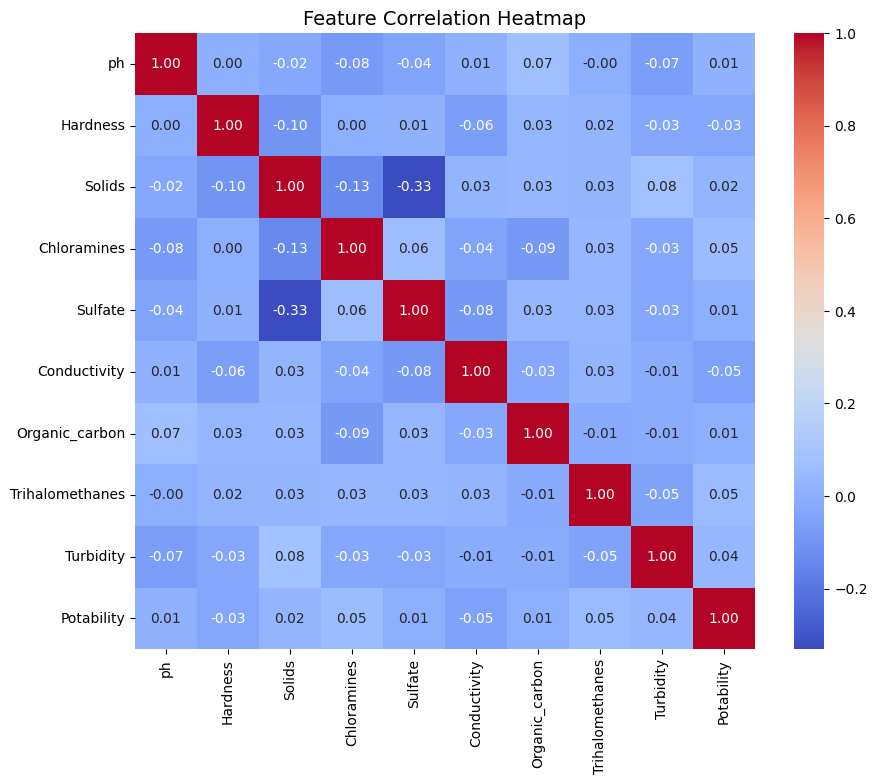

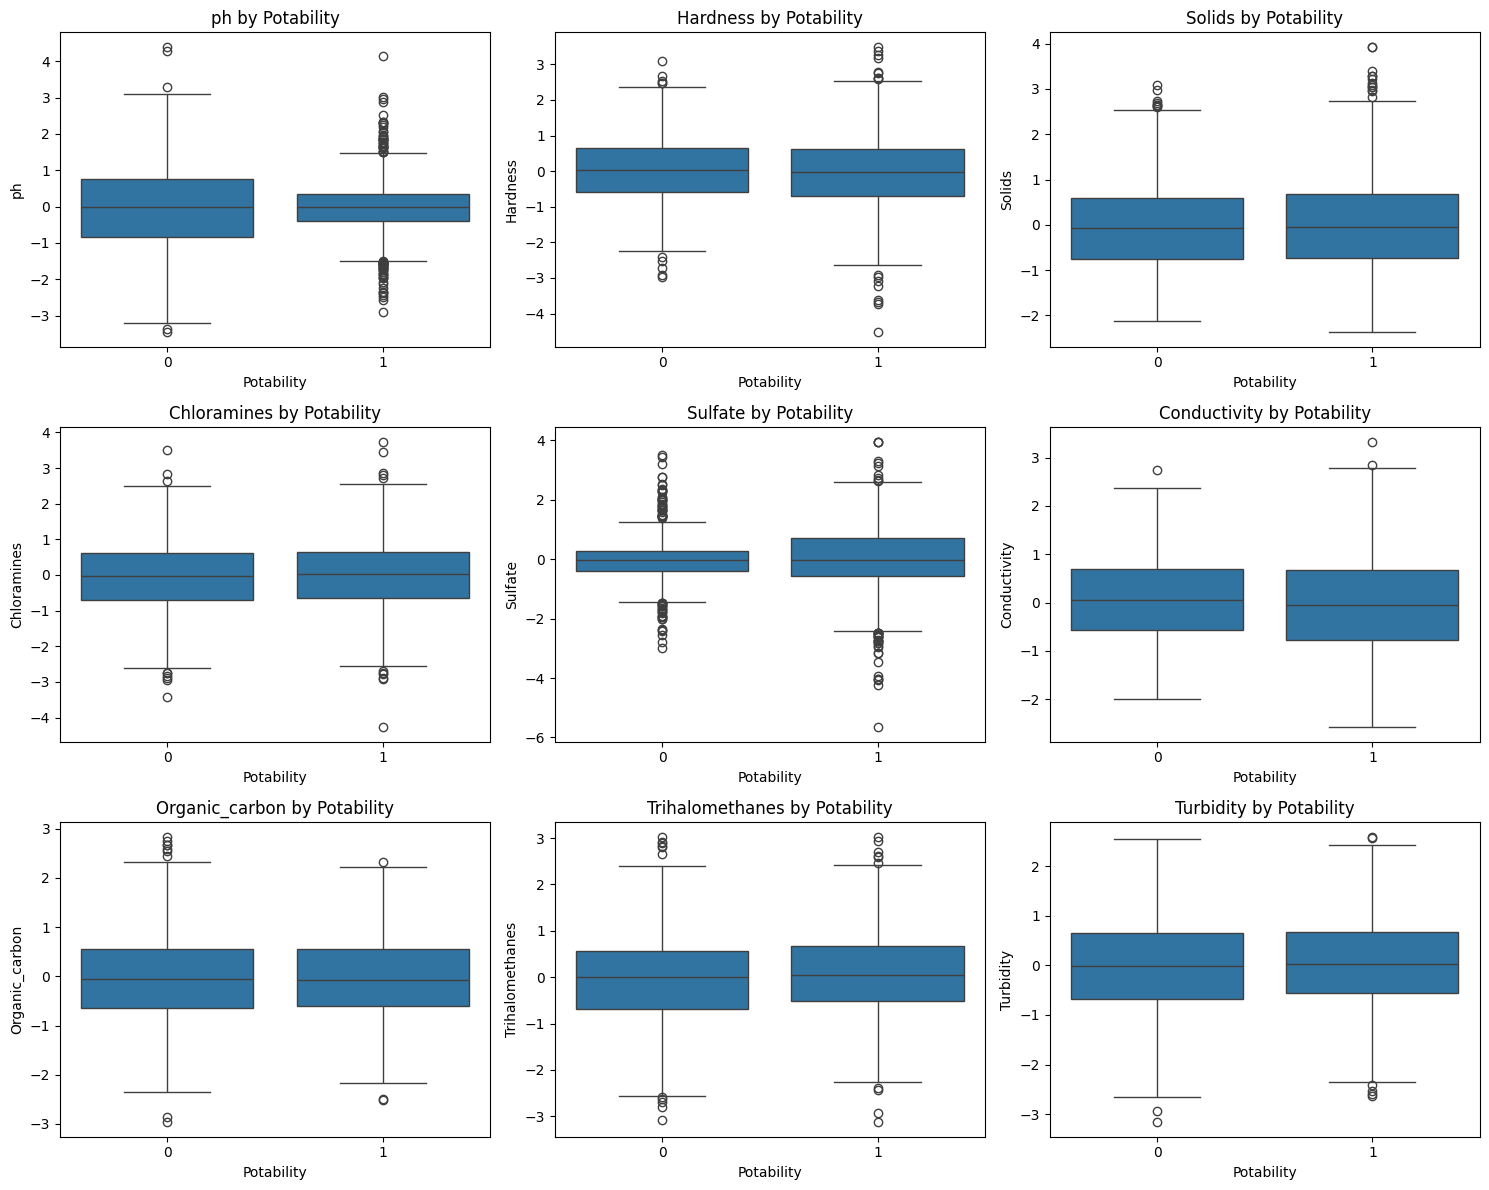

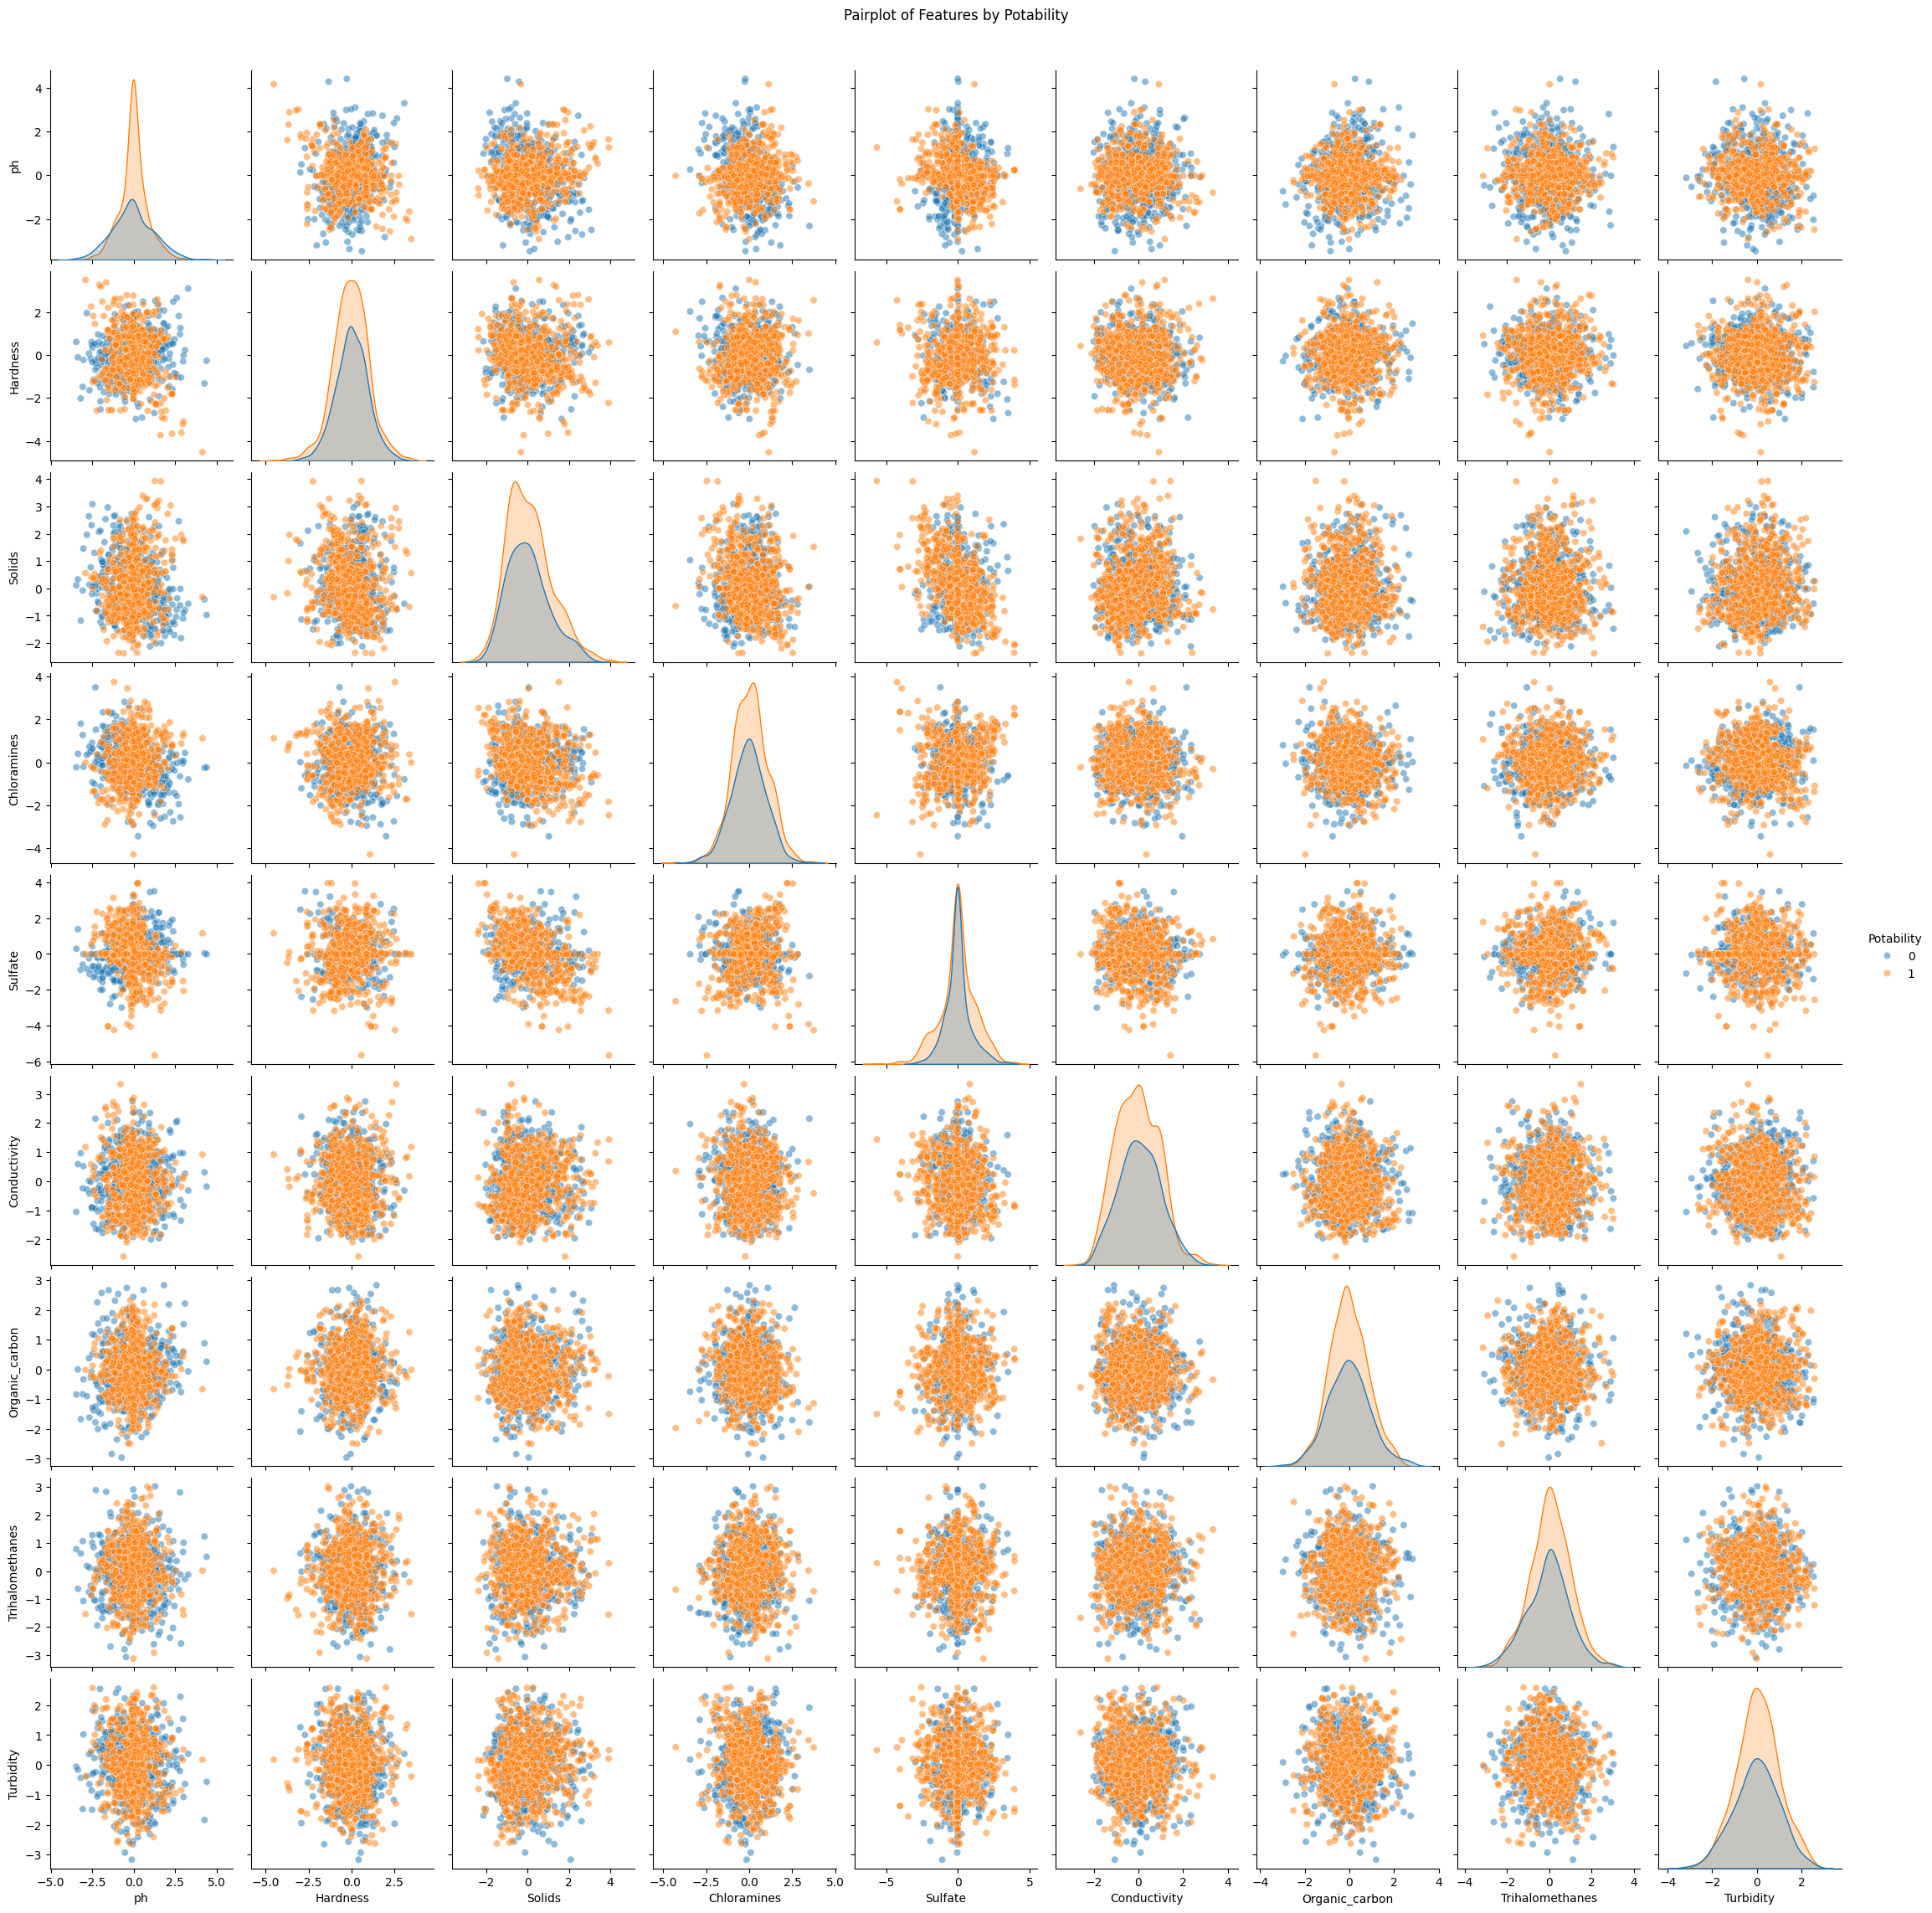

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("resampled_SMOTEENN.csv")

# Step 1: Plot Histograms for each feature
df.hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.tight_layout()
plt.suptitle("Histogram of Features", fontsize=16, y=1.02)
plt.show()

# Step 2: Correlation Heatmap to show relationships between features
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap", fontsize=14)
plt.show()

# Step 3: Box plots for each feature by 'Potability'
features = df.columns[:-1]  # Exclude 'Potability' column
plt.figure(figsize=(15, 12))

for i, feature in enumerate(features):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x="Potability", y=feature, data=df)
    plt.title(f"{feature} by Potability")

plt.tight_layout()
plt.show()

# Step 4: Pairplot to visualize pairwise relationships by 'Potability'
sns.pairplot(df, hue='Potability', diag_kind='kde', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features by Potability", y=1.02)
plt.show()
